
**Название:** Аналитик развлекательного приложения Procrastinate Pro+.

**Краткое описание:** Компания терпит убытки, несмотря на огромные вложения в рекламу.

**Цели и задачи:** Разобраться в причинах и помочь компании выйти в плюс.

**Описание исходных данных:**

    - Visits: лог сервера с данными об их посещениях
    - Orders: выгрузка их покупок за этот период
    - Costs:рекламные расходы
    
**План (декомпозиция) анализа данных:**

    - Шаг 1. Загржаем данные и подготовливаем их к анализу
    - Шаг 2. Задаем функции для расчета и анализа LTV, ROI, удержания и конверсии
    - Шаг 3. Проведём исследовательский анализ данных:
      - Определите минимальную и максимальную даты привлечения пользователей.
      - Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
      - Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
      - Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.
    - Шаг 4. Маркетинг:
      - Выясним сколько денег потратили (Всего / на каждый источник / по времени)? 
      - Выясним сколько в среднем стоило привлечение одного покупателя из каждого источника?
    - Шаг 5. Оценм окупаемость рекламы для привлечения пользователей:
      - Напишем функции для расчета.
      - Проанализируем общую окупаемость рекламы. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
      - Проанализируйте окупаемость рекламы с разбивкой по устройствам.
      - Проанализируйте окупаемость рекламы с разбивкой по странам.
      - Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам.
    - Шаг 6. Общий вывод и рекомендации для отдела маркетинга.


## Шаг 1. Загржаем данные и подготовливаем их к анализу

In [1]:
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np

In [2]:
visits = pd.read_csv('/datasets/visits_info_short.csv')
orders = pd.read_csv('/datasets/orders_info_short.csv')
costs =  pd.read_csv('/datasets/costs_info_short.csv')

In [3]:
display(visits.head())
visits.info()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [4]:
visits = visits.rename(columns={
    'User Id': 'user_id',
    'Region': 'region',
    'Device': 'device',
    'Channel': 'channel',
    'Session Start': 'session_start',
    'Session End': 'session_end'
}
                  )

In [5]:
visits.columns.tolist()

['user_id', 'region', 'device', 'channel', 'session_start', 'session_end']

In [6]:
visits['session_start'] = pd.to_datetime(visits['session_start'], format = '%Y-%m-%d %H:%M:%S')
visits['session_end'] = pd.to_datetime(visits['session_end'],   format = '%Y-%m-%d %H:%M:%S')
visits.head()

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [7]:
visits.duplicated().sum()

0

In [8]:
display(orders.head())
orders.info()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [9]:
orders = orders.rename(columns={
    'User Id': 'user_id',
    'Event Dt': 'event_dt',
    'Revenue': 'revenue',
   }
                  )

In [10]:
orders.columns.tolist()

['user_id', 'event_dt', 'revenue']

In [11]:
orders['event_dt'] = pd.to_datetime(orders['event_dt'], format = '%Y-%m-%d %H:%M:%S')
orders.head()

,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [12]:
orders.duplicated().sum()

0

In [13]:
display(costs.head())
costs.info()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [14]:
costs = costs.rename(columns={'Channel':'channel'})

In [15]:
costs.columns.tolist()

['dt', 'channel', 'costs']

In [16]:
pd.to_datetime(costs['dt']).dt.date
costs.head()

,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [17]:
costs.duplicated().sum()

0

### **Вывод**
<br> 1) Импортировали и просмотрели таблицы.
<br> 2) Провели проверку на пропущенные данные, дубликаты, и привели названия столбцов к стандартам.
<br> 3) Преобразовали данные о времени для дальнейших расчётов.



## Шаг 2. Задаем функции для расчета и анализа LTV, ROI, удержания и конверсии

In [18]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

In [19]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [20]:
#проверка функции
# получаем профили пользователей
#profiles = get_profiles(visits, orders, costs)
#print(profiles.head(5)) 

In [21]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 


In [22]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [23]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

### **Вывод** 
<br>Собрали функции для создания профилей, расчёта удержания, конверсии, LTV и ROI из пройденного спринта: get_profiles(), get_retention(), get_conversion() и get_ltv().

## Шаг 3. Проведём исследовательский анализ данных



In [24]:
# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

In [25]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
display(profiles.head(5))

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


### Создаем пользовательские профили. Определите минимальную и максимальную даты привлечения пользователей.

In [26]:
profiles.agg({'dt': ['min', 'max']})

,dt
min,2019-05-01
max,2019-10-27


### Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.

In [27]:
profiles.groupby('region').agg({'user_id': 'nunique', 'payer': 'mean'}).sort_values(by=['payer'])

,user_id,payer
region,,
France,17450,0.037994
UK,17575,0.039829
Germany,14981,0.041119
United States,100002,0.069019


### Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.

In [28]:
profiles.groupby('device').agg({'user_id': 'nunique', 'payer':'mean'}).sort_values(by=['payer'])

,user_id,payer
device,,
PC,30455,0.050468
Android,35032,0.058518
iPhone,54479,0.062079
Mac,30042,0.063644


### Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

In [29]:
profiles.groupby('channel').agg({'user_id': 'nunique', 'payer':'mean'}).sort_values(by=['payer'])

,user_id,payer
channel,,
organic,56439,0.020553
OppleCreativeMedia,8605,0.027077
LeapBob,8553,0.030633
MediaTornado,4364,0.035747
YRabbit,4312,0.038265
WahooNetBanner,8553,0.052964
RocketSuperAds,4448,0.079137
TipTop,19561,0.096007
lambdaMediaAds,2149,0.104700


### Вывод
<br> 1) Получили профили пользователей. Для этого вызовали функцию get_profiles(), передав ей данные о посещениях, покупках и тратах на рекламу.
<br> 2) Определили минимальную и максимальную даты привлечения пользователей, из первых 5ти записей, делаю вывод, что данные пользователи, были в приложении единождый (одинь день).
<br> 3) Выявили страны, из которых пользователи  заходят в приложение, на США приходится больше всего платящих пользователей.
<br> 4) Основными устройствами, которыми пользуются пользователи - это PC, Android, Iphone, Mac. Больше всего платящих пользователей с устройством Iphone.
<br> 5) Больше всего платящих пользователей пришло с канала "FaceBoom", в тройке лидеров TipTop и OppleCreativeMedia.
<br>

## Шаг 4. Маркетинг

In [30]:
profiles = profiles.query('channel != "organic"') #отфильтруем орагнических пользщователй из источника исследования

In [31]:
profiles.agg({'acquisition_cost': 'sum'}) #общая сумма расходов

acquisition_cost    105497.3
dtype: float64

In [32]:
profiles.groupby('channel').agg({'acquisition_cost': 'sum'}).sort_values(by=['acquisition_cost'])#сумма трат по каналам

,acquisition_cost
channel,
YRabbit,944.22
MediaTornado,954.48
lambdaMediaAds,1557.60
LeapBob,1797.60
RocketSuperAds,1833.00
OppleCreativeMedia,2151.25
AdNonSense,3911.25
WahooNetBanner,5151.00
FaceBoom,32445.60


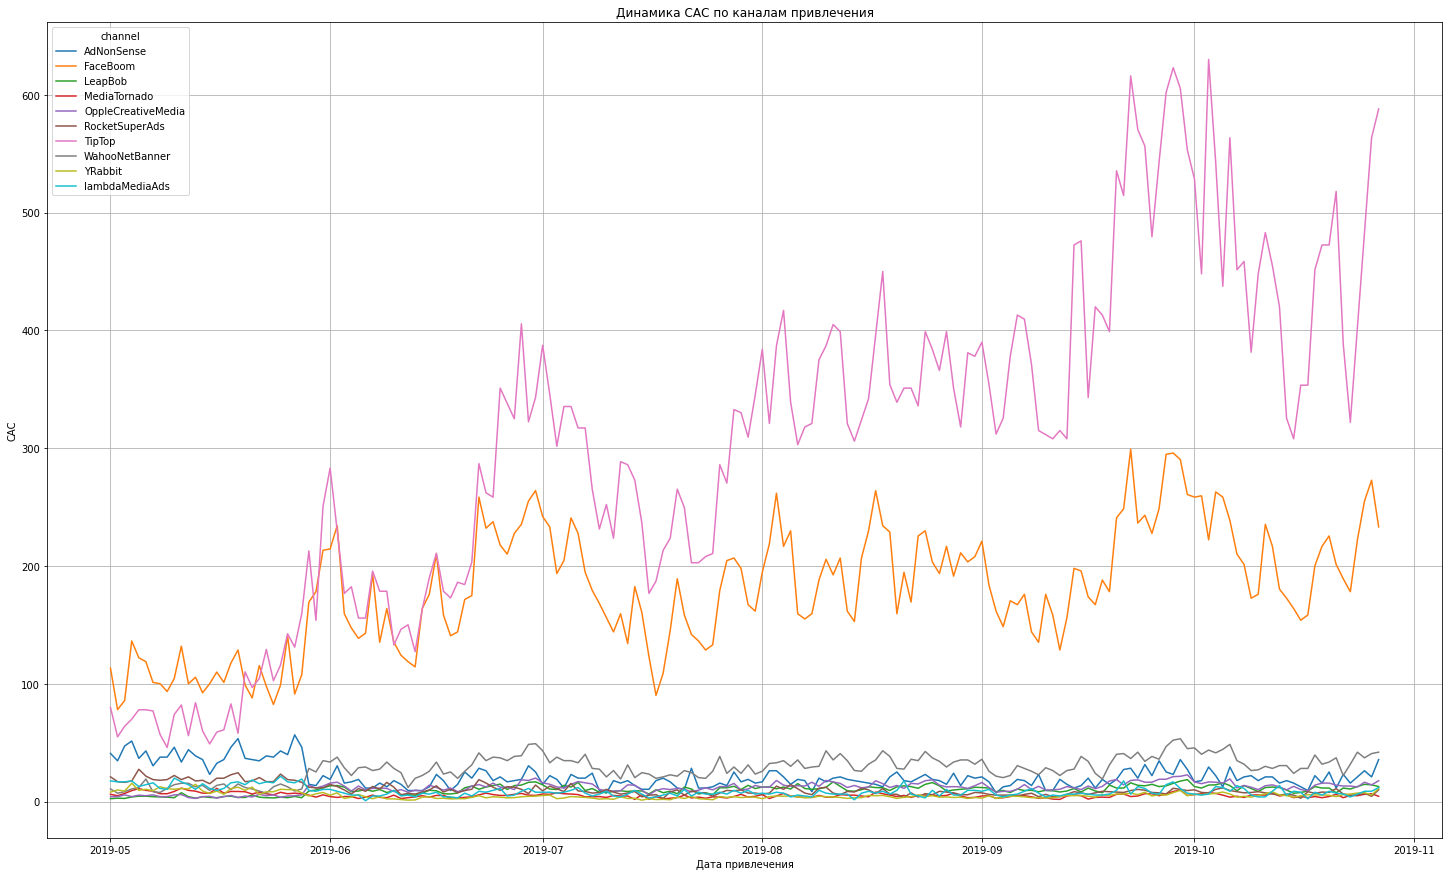

In [33]:
profiles.pivot_table(index='dt', columns='channel', values='acquisition_cost', aggfunc='sum').plot(grid=True, figsize=(25,15))
plt.ylabel('CAC')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

In [34]:
profiles.groupby('channel').agg({'acquisition_cost': 'mean'}).sort_values(by=['acquisition_cost']) #CAC в среднем по источникам


,acquisition_cost
channel,
LeapBob,0.210172
MediaTornado,0.218717
YRabbit,0.218975
OppleCreativeMedia,0.250000
RocketSuperAds,0.412095
WahooNetBanner,0.602245
lambdaMediaAds,0.724802
AdNonSense,1.008054
FaceBoom,1.113286


In [35]:
profiles.agg({'acquisition_cost': 'mean'})#общий CAC в среднем


acquisition_cost    1.127481
dtype: float64

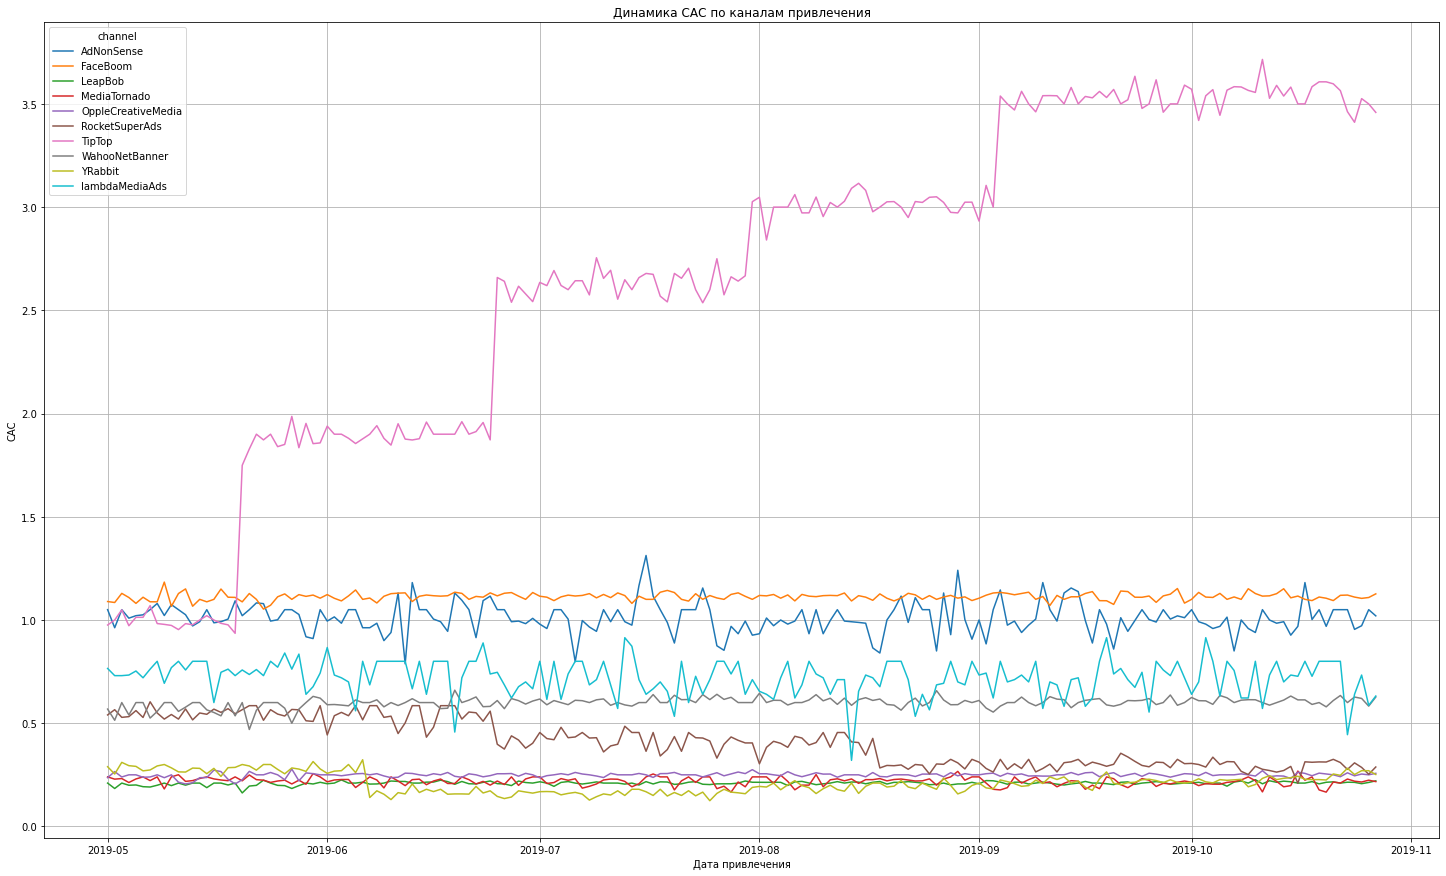

In [36]:
profiles.pivot_table(index='dt', columns='channel', values='acquisition_cost', aggfunc='mean').plot(grid=True, figsize=(25,15))
plt.ylabel('CAC')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

In [37]:
# рассчитываем LTV и ROI

ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)

roi  # таблица ROI

,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
channel,,,,,,,,,,,,,,,,
AdNonSense,3702,1.008023,0.501010,0.584460,0.639288,0.678069,0.701069,0.726752,0.748147,0.761519,0.782922,0.796294,0.800573,0.808597,0.820631,0.831337
FaceBoom,27544,1.113419,0.526040,0.593510,0.629343,0.654599,0.671035,0.682914,0.695801,0.704818,0.711685,0.719204,0.724119,0.729488,0.734210,0.737790
LeapBob,8103,0.210000,0.509752,0.741436,0.978967,1.120908,1.236450,1.374282,1.498034,1.589535,1.759730,1.877030,1.988470,2.085248,2.179087,2.252399
MediaTornado,4167,0.219035,0.627684,0.874814,1.127410,1.340729,1.516873,1.675432,1.773841,1.910531,2.008962,2.107371,2.216726,2.320602,2.402610,2.436519
OppleCreativeMedia,8139,0.249908,0.389100,0.526504,0.686996,0.826849,0.964769,1.065354,1.161037,1.238564,1.314661,1.388265,1.457448,1.507006,1.580649,1.637075
RocketSuperAds,4251,0.417431,0.497256,0.763336,0.948932,1.092347,1.235204,1.367935,1.531090,1.646391,1.767923,1.892809,1.991795,2.070538,2.152657,2.237019
TipTop,18498,2.757774,0.124575,0.180359,0.226321,0.268272,0.305449,0.339298,0.367570,0.397585,0.424763,0.451627,0.475535,0.497310,0.517679,0.539532
WahooNetBanner,8082,0.601856,0.317853,0.484298,0.629588,0.737309,0.858780,0.946188,1.049868,1.126808,1.205193,1.271878,1.350049,1.411192,1.477881,1.526304
YRabbit,4102,0.217087,0.752238,0.983122,1.179250,1.400049,1.641119,1.786814,1.910094,2.022179,2.123045,2.212703,2.313569,2.414457,2.516446,2.578086


In [38]:
ltv #таблица LTV

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
channel,,,,,,,,,,,,,,,
AdNonSense,3702,0.505030,0.589149,0.644417,0.683509,0.706694,0.732582,0.754149,0.767628,0.789203,0.802682,0.806996,0.815084,0.827215,0.838006
FaceBoom,27544,0.585703,0.660825,0.700722,0.728842,0.747143,0.760369,0.774718,0.784757,0.792404,0.800775,0.806247,0.812226,0.817483,0.821469
LeapBob,8103,0.107048,0.155702,0.205583,0.235391,0.259654,0.288599,0.314587,0.333802,0.369543,0.394176,0.417579,0.437902,0.457608,0.473004
MediaTornado,4167,0.137485,0.191615,0.246943,0.293667,0.332249,0.366979,0.388534,0.418474,0.440034,0.461589,0.485541,0.508294,0.526256,0.533684
OppleCreativeMedia,8139,0.097239,0.131578,0.171686,0.206636,0.241103,0.266240,0.290152,0.309527,0.328544,0.346938,0.364228,0.376613,0.395017,0.409118
RocketSuperAds,4251,0.207570,0.318640,0.396114,0.455980,0.515613,0.571019,0.639125,0.687255,0.737986,0.790118,0.831437,0.864307,0.898586,0.933801
TipTop,18498,0.343550,0.497389,0.624141,0.739834,0.842358,0.935707,1.013676,1.096450,1.171400,1.245485,1.311417,1.371467,1.427640,1.487908
WahooNetBanner,8082,0.191302,0.291477,0.378921,0.443754,0.516862,0.569469,0.631870,0.678176,0.725353,0.765488,0.812535,0.849334,0.889472,0.918615
YRabbit,4102,0.163301,0.213423,0.256000,0.303932,0.356265,0.387894,0.414656,0.438988,0.460885,0.480349,0.502245,0.524147,0.546287,0.559668


### Вывод
<br>1) Выявили, что всего на рекламу было затрачено 105497.3 у.е.(условных единиц), преположу что это в USD.
<br>2) Вычислили, что больше всего на рекламы затратили TipTop (54751,30 USD), FaceBoom (32445,60 USD), WahooNetBanner (5151 USD),у остальных до 4000 USD.
<br>3) А так же высчитали CAC в среднем по источникам. Для TipTop (2,79 USD), FaceBoom (1,11 USD), AdNonSense (1 USD), для остальных меньше 1 USD.


## Шаг 5. Оцените окупаемость рекламы для привлечения пользователей


### Функции для расчета


In [39]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [40]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = '13'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Динамика удержания платящих пользователей на 14-й день')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Динамика удержания неплатящих пользователей на 14-й день')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Удержание платящих пользователей'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Удержание неплатящих пользователей'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [41]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей на 14-й день')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [42]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [43]:
#profiles = get_profiles(visits, orders, costs)
#print(profiles.head(5)) 

### Проанализируем общую окупаемость рекламы. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

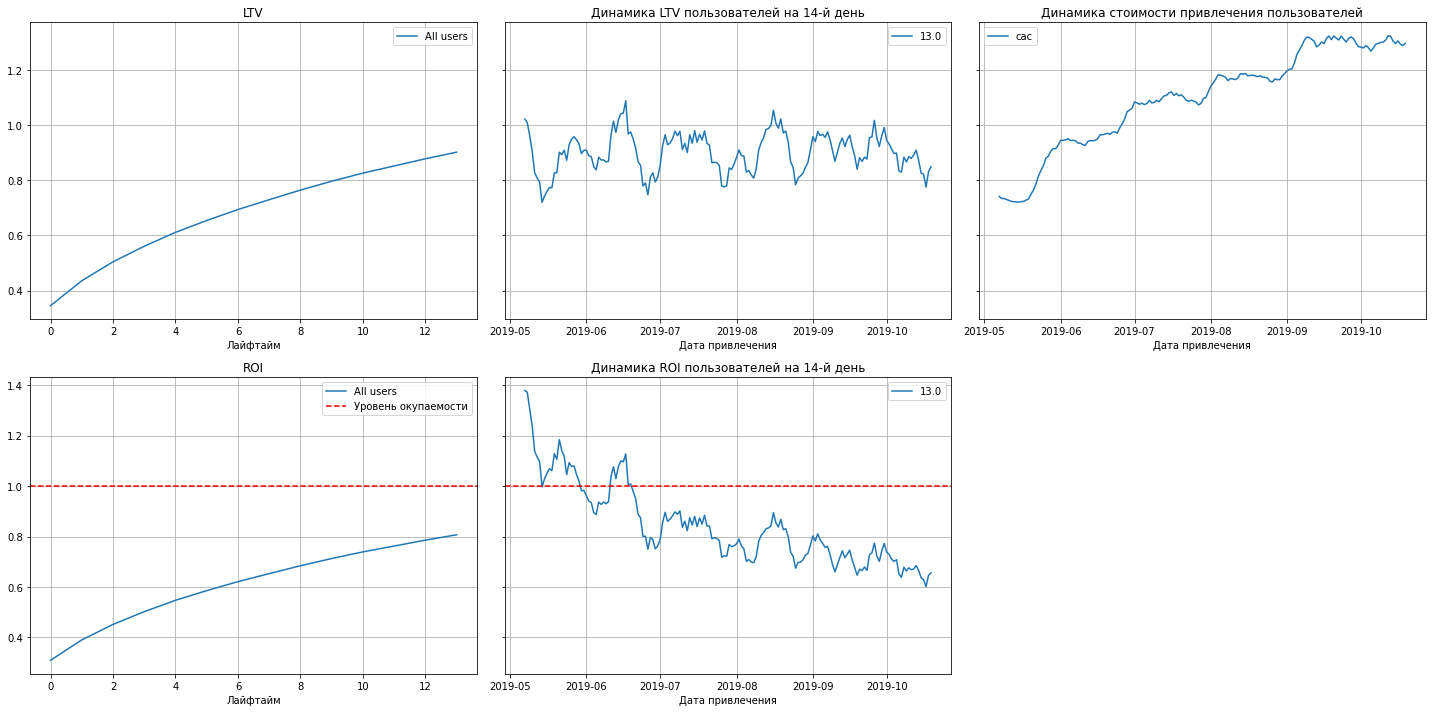

In [44]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

#### Вывод
<br> 1) ROI в конце недели доходит до 80%.
<br> 2) В начале недели у CAC был стремительный рост, к концу недели САС стал расти плавно.
<br> 3) LTV плавно растет от нуля с возможным пересечением единицы. Значит, дело не в ухудшении качества пользователей.
<br> 4) Общий вовыод - Реклама не окупается. 


### Проанализируйте окупаемость рекламы с разбивкой по устройствам

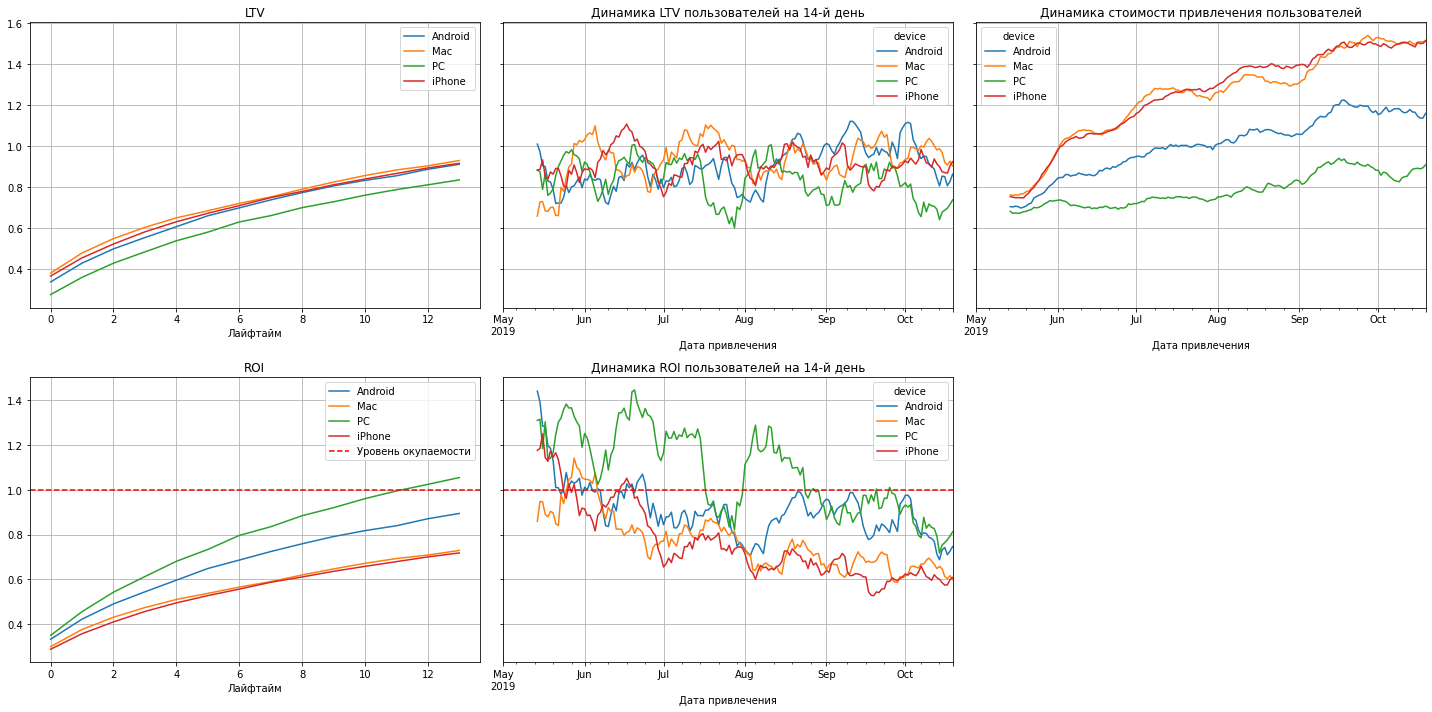

In [45]:
# смотрим окупаемость с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

#### Вывод

<br> 1) Хорошо конвертируются пользоватеои PC, а вот пользователи Anfroid, Iphone и Mac плохо конвертируются.
<br> 2) LTV все также стабильно растет вверх.
<br> 3) На PC средств на привлечение пользователей тратят меньше всего, при этом динамика ROI показывает хороший результат.
<br> 4)Динамика LTV практически стабильна для всех пользователей.


### Проанализируйте окупаемость рекламы с разбивкой по странам

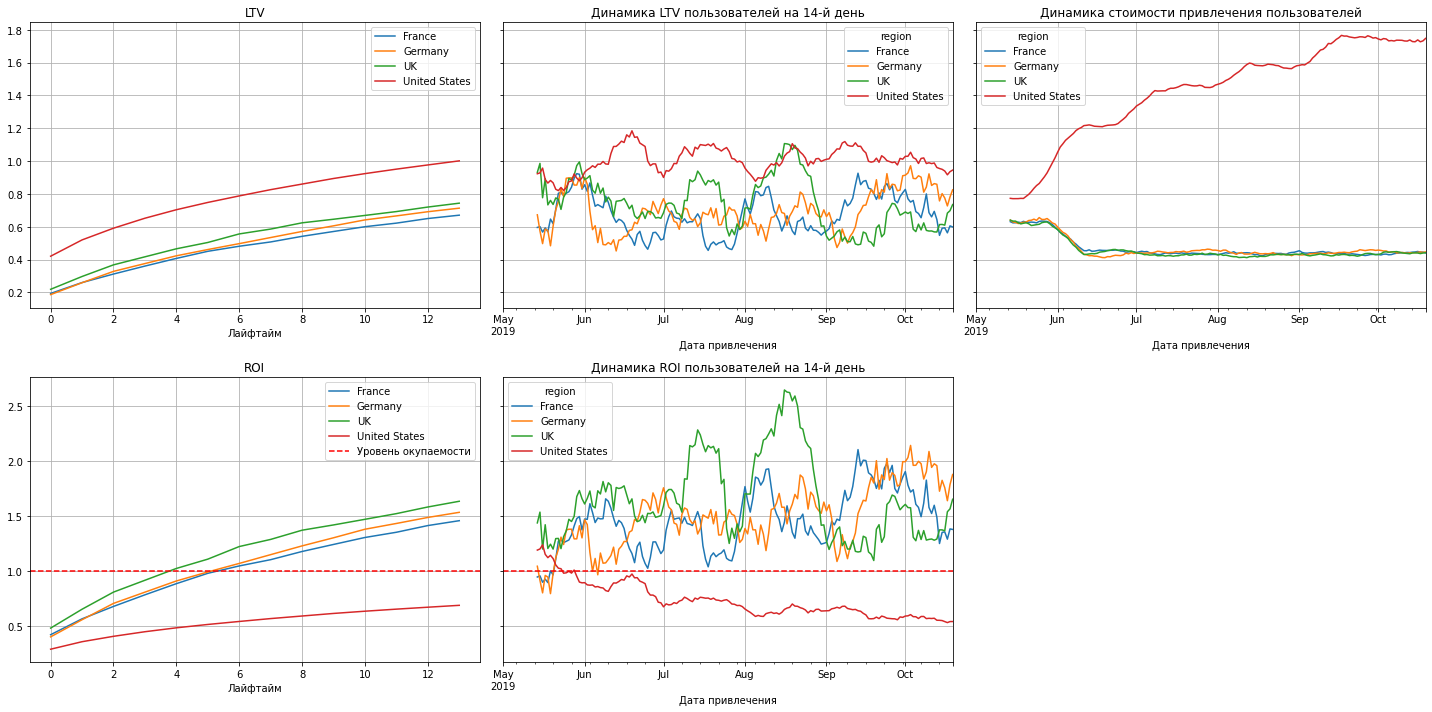

In [46]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 
# смотрим окупаемость с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

#### Вывод 
<br>1) В штатах на привлечение пользователей тратять в 4-5 раз больше, чем в других странах, но к сожалению не окупается.
<br>2) LTV стабилен.
<br>3) Лучше всего окупается UK, далее GDR и France практически одинаковы.
<br>4) Динамика LTV выше в штатах, чуть хуже во France, UK, GDR.


### Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам

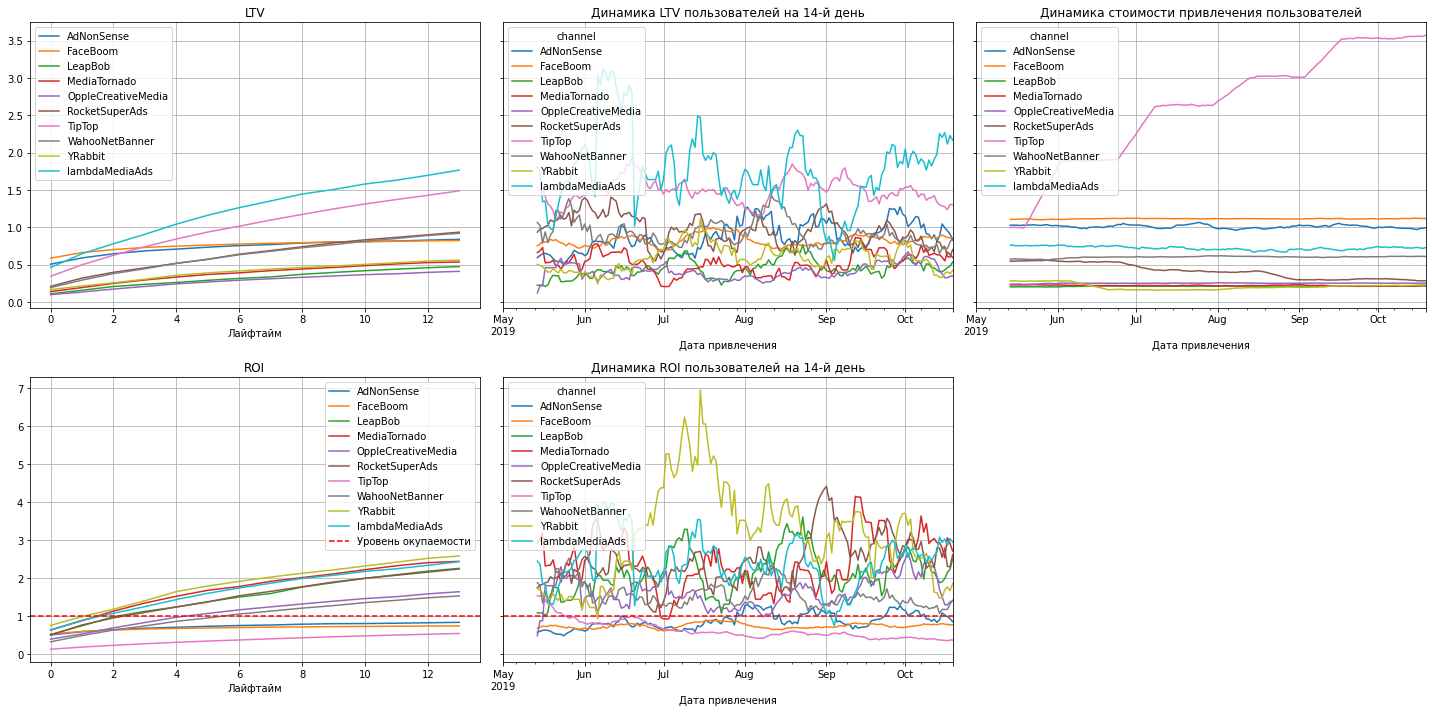

In [47]:
# смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

#### Вывод
<br> 1) LTV плавно растет
<br> 2) На TipTop затрачивается больше средств, чем другие источники.
<br> 3) Хорошая динамика ROI у источника YRabbit, затрат немного, но привлекают достаточное кол-во.
<br> 4) Динамика LTV LambdaMediaAds и TipTop на уровень выше других.

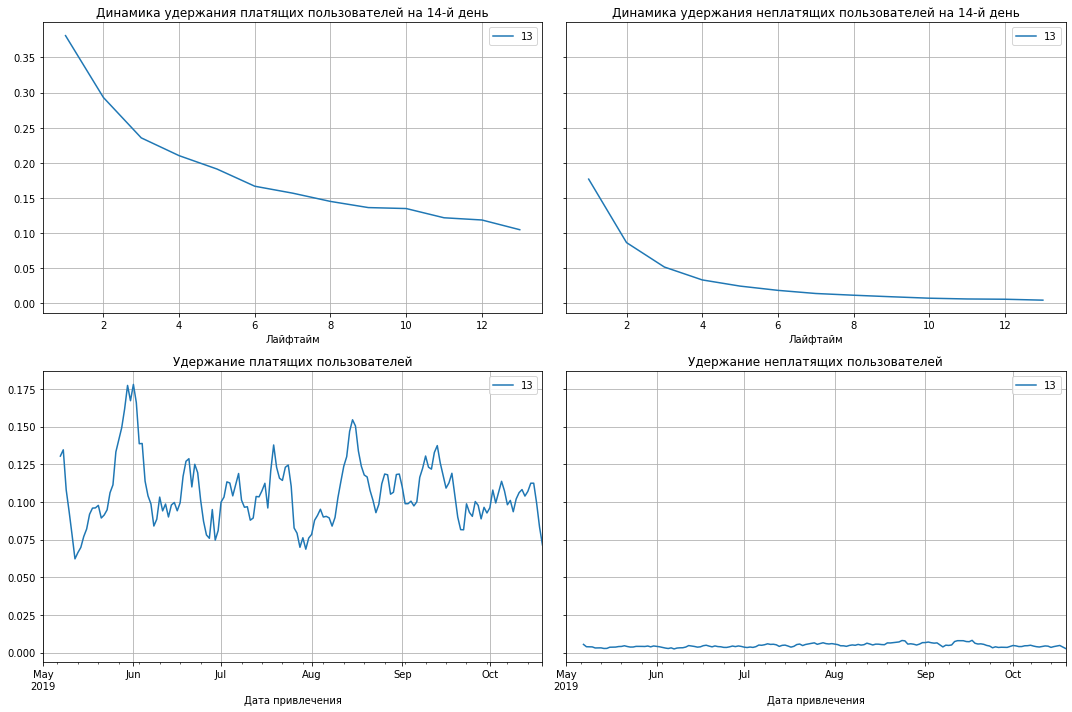

In [48]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days)

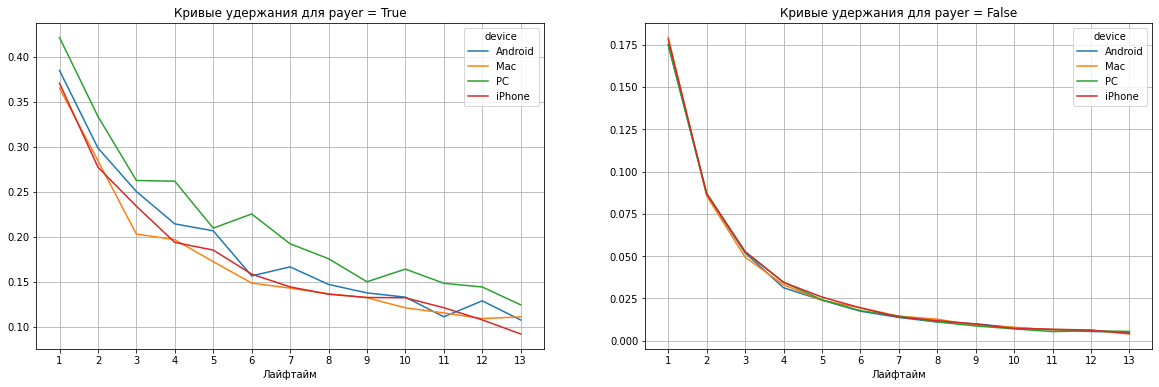

In [49]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)

# --- строим кривые удержания ---

plt.figure(figsize=(20, 6))

# берём таблицу удержания retention
# исключаем размеры когорт и удержание первого дня
report = retention.drop(columns=['cohort_size', 0])

for i, payer in enumerate(profiles['payer'].unique()):
    report.query('payer == @payer').droplevel('payer').T.plot(
        grid=True,
        xticks=list(report.columns.values),
        ax=plt.subplot(1, 2, i + 1),
    )
    plt.xlabel('Лайфтайм')
    plt.title('Кривые удержания для payer = {}'.format(payer))

plt.show()

#### Вывод 
Графики удержаний меняются по всем каналам примерно одинаково, самые качественные показатели платящих клиентов это на PC хуже у MAC, Iphone. У не платящих все стабильно.
Графики удержания по каналам источников привлечения пользователей для платящих клиентов хуже всего у FAceBoom,AdNonSense. Хорошие показатели у WahooNetBannerLambdaMediaAds. Графики не платящих клиентов выглядят стабильнее, чем удержание платящих.

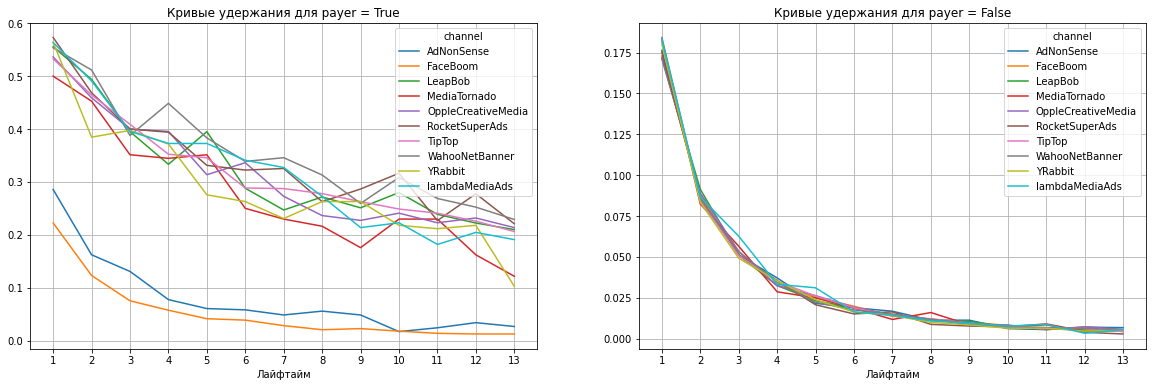

In [50]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)


# --- строим кривые удержания ---

plt.figure(figsize=(20, 6))

# берём таблицу удержания retention
# исключаем размеры когорт и удержание первого дня
report = retention.drop(columns=['cohort_size', 0])

for i, payer in enumerate(profiles['payer'].unique()):
    report.query('payer == @payer').droplevel('payer').T.plot(
        grid=True,
        xticks=list(report.columns.values),
        ax=plt.subplot(1, 2, i + 1),
    )
    plt.xlabel('Лайфтайм')
    plt.title('Кривые удержания для payer = {}'.format(payer))

plt.show()

#### Вывод
Графики удержания по каналам источников привлечения пользователей для платящих клиентов хуже всего у FAceBoom,AdNonSense. Хорошие показатели у WahooNetBanner, LambdaMediaAds. Графики не платящих клиентов выглядят стабильнее, чем удержание платящих.

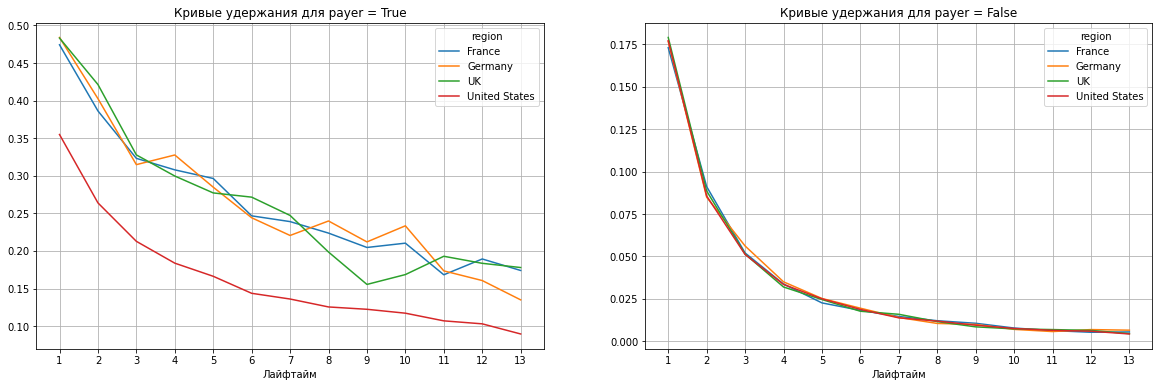

In [51]:
retention_raw, retention, retention_history = get_retention(
    profiles, visits, datetime(2019, 11, 1).date(), 14, dimensions=['region']
)


# --- строим кривые удержания ---

plt.figure(figsize=(20, 6))

# берём таблицу удержания retention
# исключаем размеры когорт и удержание первого дня
report = retention.drop(columns=['cohort_size', 0])

for i, payer in enumerate(profiles['payer'].unique()):
    report.query('payer == @payer').droplevel('payer').T.plot(
        grid=True,
        xticks=list(report.columns.values),
        ax=plt.subplot(1, 2, i + 1),
    )
    plt.xlabel('Лайфтайм')
    plt.title('Кривые удержания для payer = {}'.format(payer))

plt.show()

#### Вывод 
Графики удержания по регионам для платящих клиентов хуже всего у США, в остальных странах все более менее одинаково, но чуть лучше у UK. 
По не платящим клиентам все одинаково.

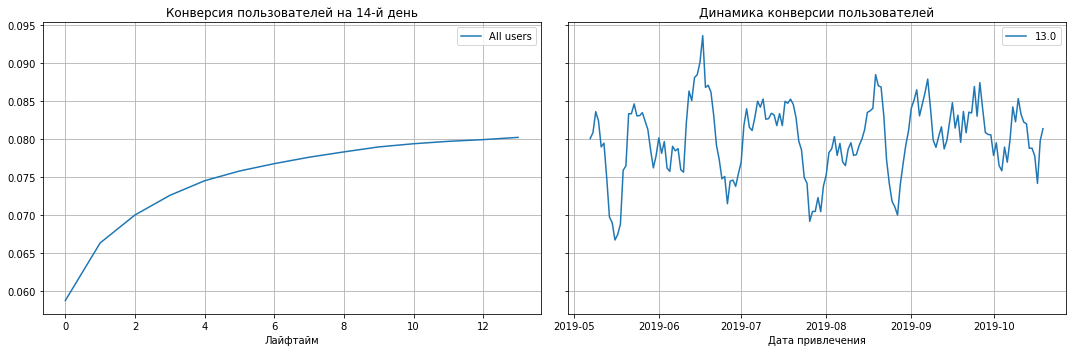

In [52]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

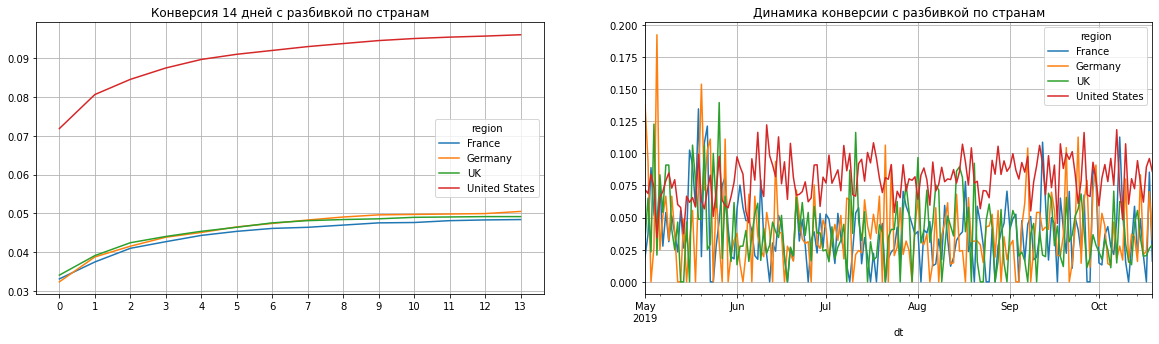

In [53]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['region']
)

plt.figure(figsize=(20, 5)) # размер сетки для графиков

# для кривых конверсии исключаем размеры когорт
report = conversion.drop(columns=['cohort_size'])
report.T.plot(
    # строим кривые конверсии в первой ячейке таблицы графиков
    grid=True, xticks=list(report.columns.values), ax=plt.subplot(1, 2, 1)
)
plt.title('Конверсия 14 дней с разбивкой по странам')

# для графика истории изменений 
# преобразуем таблицу динамики конверсии
report = (
    conversion_history[1]
    .reset_index()
    .pivot_table(index='dt', columns='region', values=1, aggfunc='mean')
    .fillna(0)  # заполняем пропуски на случай, если они возникнут
)
report.plot(
    # во второй ячейке строим график истории изменений
    grid=True, ax=plt.subplot(1, 2, 2)
)
plt.title('Динамика конверсии с разбивкой по странам')

plt.show() 

#### Вывод 
США не всегда конвертировался лучше UK и GDR, новые пользователи из GDR и UK с мая по июнь показывали более высокую конверсию. В остальные жни лучший показатель у США, у France на более низком уровне.

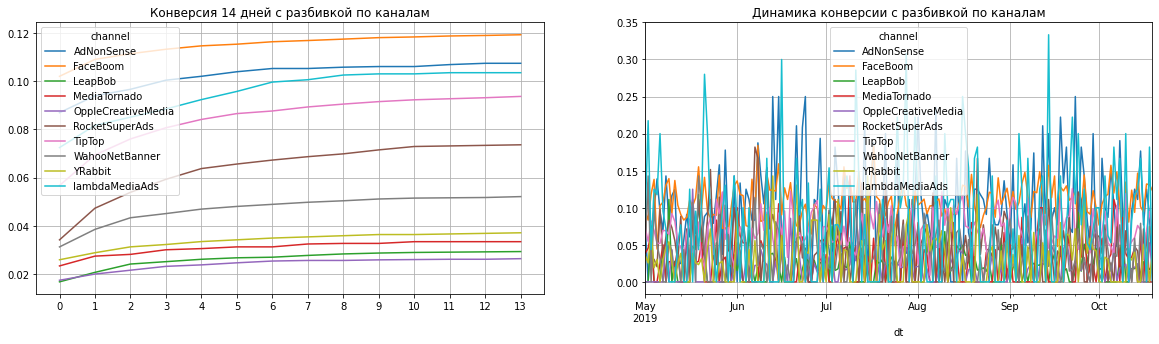

In [54]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['channel']
)

plt.figure(figsize=(20, 5)) # размер сетки для графиков

# для кривых конверсии исключаем размеры когорт
report = conversion.drop(columns=['cohort_size'])
report.T.plot(
    # строим кривые конверсии в первой ячейке таблицы графиков
    grid=True, xticks=list(report.columns.values), ax=plt.subplot(1, 2, 1)
)
plt.title('Конверсия 14 дней с разбивкой по каналам')

# для графика истории изменений 
# преобразуем таблицу динамики конверсии
report = (
    conversion_history[1]
    .reset_index()
    .pivot_table(index='dt', columns='channel', values=1, aggfunc='mean')
    .fillna(0)  # заполняем пропуски на случай, если они возникнут
)
report.plot(
    # во второй ячейке строим график истории изменений
    grid=True, ax=plt.subplot(1, 2, 2)
)
plt.title('Динамика конверсии с разбивкой по каналам')

plt.show() 

#### Вывод
Хорошо конвертируется FaceBoom, AdNonSense, LambdaMediaAds, хуже WahooNetBanner, LeapBob. Если рассмотреть конверсию за весь период, лидирует LambdaMediaAds, AdNonSense.

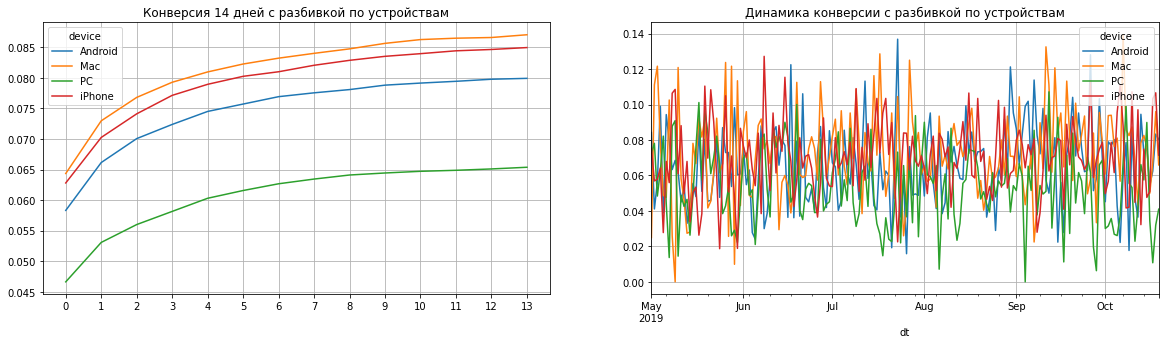

In [55]:
conversion_raw, conversion, conversion_history = get_conversion(
    profiles, orders, datetime(2019, 11, 1).date(), 14, dimensions=['device']
)

plt.figure(figsize=(20, 5)) # размер сетки для графиков

# для кривых конверсии исключаем размеры когорт
report = conversion.drop(columns=['cohort_size'])
report.T.plot(
    # строим кривые конверсии в первой ячейке таблицы графиков
    grid=True, xticks=list(report.columns.values), ax=plt.subplot(1, 2, 1)
)
plt.title('Конверсия 14 дней с разбивкой по устройствам')

# для графика истории изменений 
# преобразуем таблицу динамики конверсии
report = (
    conversion_history[1]
    .reset_index()
    .pivot_table(index='dt', columns='device', values=1, aggfunc='mean')
    .fillna(0)  # заполняем пропуски на случай, если они возникнут
)
report.plot(
    # во второй ячейке строим график истории изменений
    grid=True, ax=plt.subplot(1, 2, 2)
)
plt.title('Динамика конверсии с разбивкой по устройствам')

plt.show() 

#### Вывод
Хорошо конвертируются пользователи Mac, Iphone, хуже PC. Если рассмотреть весь период, то ничего не поменяется по сравнению на 14 день.

## Шаг 6. Общий вывод
- Выделите причины неэффективности привлечения пользователей;
- Сформируйте рекомендации для отдела маркетинга для повышения эффективности.

<br>Реклама, направленная на привлечение пользователей в целом не окупается.
В исселодвании выявили, что пользователей с утройством Iphone'а в 1,5 больше Android'а, CAC у пользователей Iphone в несколько раз больше по сравнению с остальными, но при этом ROI к сожалению очень низкий. Возможна какая-то техническая причина.
<br>Рекомендую отделу маркетинга обратиться к разработчикам и проверить файлы на наличие ошибок у пользователей IOS, с целью их выявления и устранения.
        <br>- на рекламу в США для привлечения пользователей тратят большие суммы, но это не окупается. Динамика LTV слабовато.
        <br>- источник привлечения пользователей TipTop не окупается, затраты на него в 4-5 раз выше остальных. Динамика ROI очень низкая.
        <br>- у источника привлечения пользователей FaceBoom плохие показатели динамики LTV и ROI.
        <br>- у источника привлечения пользователей YRabbitочень хорошие показали динамики LTV, ROI и CAC.
        <br>- у пользователей PC отличные показатели по всем параметрам.
    
<br> Маркетологам, чтобы решить вопрос с окупаемостью в США следует обратить внимание на источник привлечения пользователей YRabbit, он в 5 раз обойдется дешевле, при этом привлечет в несколько раз больше пользователей. Возможно стоит рассмотреть устройства, в которых пользователи проводят больше времени и на них нацелить дополнительные ресурсы. 
        <br> В Европе не так хорошо обстоят дела с пользователями устройств на Iphone, Mac, есть вероятность какого-то бага или же функционально он не так хорош, как на PC. Стоит обратиться к разработчикам и проверить это. Так же стоит рассмотреть менее бюджетные источники привлечения пользователей, это поможет заработать дополнительные средства.
        <br> США не всегда конвертировался лучше UK и GDR, новые пользователи из GDR и UK с мая по июнь показывали более высокую конверсию. В остальные дни лучший показатель у США, у France на более низком уровне.
    <br> Графики удержаний меняются по всем каналам примерно одинаково, самые качественные показатели платящих клиентов это на PC, хуже у MAC, Iphone. У не платящих все стабильно. Графики удержания по каналам источников привлечения пользователей для платящих клиентов хуже всего у FAceBoom,AdNonSense. Хорошие показатели у WahooNetBanner, LambdaMediaAds. Графики не платящих клиентов выглядят стабильнее, чем удержание платящих.
    <br> Графики удержания по регионам для платящих клиентов хуже всего у США, в остальных странах все более менее одинаково, но чуть лучше у UK. По не платящим клиентам все одинаково.
    <br> Хорошо конвертируется FaceBoom, AdNonSense, LambdaMediaAds, хуже WahooNetBanner, LeapBob. Если рассмотреть конверсию за весь период, лидирует LambdaMediaAds, AdNonSense.
    <br> на 14 день хорошо конвертируются пользователи Mac, Iphone, хуже PC. Если рассмотреть весь период, то ничего не поменяется по сравнению на 14 день.
    <br> Маркетологам дам рекомендации рассмотреть источник привлечения пользователей WahooNetBanner(но нужно быть осторожным, так как конверсия на больший период времени у него не так хороша), в приоритете LambdaMediaAds и AdNonSense, так как у них хорошие показатели, минимально вкладывать в FaceBoom(хотя конверсия хорошая), так как он себя не окупает совсем.